# Clasificación: Predicción en la clasificación a partir del histórico de datos

La dirección deportiva de un club de fútbol español nos ha pedido desarrollar un modelo de machine learning con el que podamos predecir si un equipo va a quedar entre los diez primeros o no. La idea que tienen es que si se tiene un histórico de datos y se puede predecir si un equipo estará entre los mejores o no en base a su performance en esa temporada, podrían sacar conclusiones antes de final de temporada y anticiparse a lo que está por venir.
<br>
<br>
Nos comentan en la reunión que el histórico de partidos se refiere desde la temporada 16/17 hasta la 18/19, y en las principales ligas europeas: España, Italia, Alemania, Francia e Inglaterra. Y también nos dicen que en este dataset sólo tienen los goles que hizo el equipo, los goles que encajó y la posición en la que quedó. 

In [1]:
# Cargamos las librerías

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sn

import warnings
warnings.filterwarnings(action="ignore")

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [2]:
# Cargamos el dataset
dt = pd.read_csv('data/Clasificacion.csv')

In [3]:
dt.head()

,TeamName,CompName,Season,Goals,Goals_Against,Position,Best_Teams
0,Udinese Calcio,Serie A,2018-2019,39,53,12°,0
1,Torino FC,Serie A,2018-2019,52,37,7°,1
2,Bologna FC 1909,Serie A,2018-2019,48,56,10°,1
3,SPAL 2013,Serie A,2018-2019,44,56,13°,0
4,ACF Fiorentina,Serie A,2018-2019,47,45,16°,0


Tenemos una tabla con <strong>7 columnas</strong>, la llamada 'Best_Teams', que nos ofrece un valor booleano es la que te dice si el equipo quedó en la primera mitad de la tabla (1) o no (0).

In [4]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 7 columns):
TeamName         294 non-null object
CompName         294 non-null object
Season           294 non-null object
Goals            294 non-null int64
Goals_Against    294 non-null int64
Position         294 non-null object
Best_Teams       294 non-null int64
dtypes: int64(3), object(4)
memory usage: 16.2+ KB


In [5]:
dt.describe()

,Goals,Goals_Against,Best_Teams
count,294.000000,294.000000,294.000000
mean,51.493197,51.493197,0.500000
std,18.056745,13.117152,0.500853
min,22.000000,22.000000,0.000000
25%,38.000000,42.250000,0.000000
50%,48.000000,52.000000,0.500000
75%,60.000000,60.000000,1.000000
max,116.000000,94.000000,1.000000


Tenemos a un equipo que recibió 94 goles. Y el <strong>75% de los equipos no han metido más de 60 goles en una temporada.</strong>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C243A82088>,
      dtype=object)

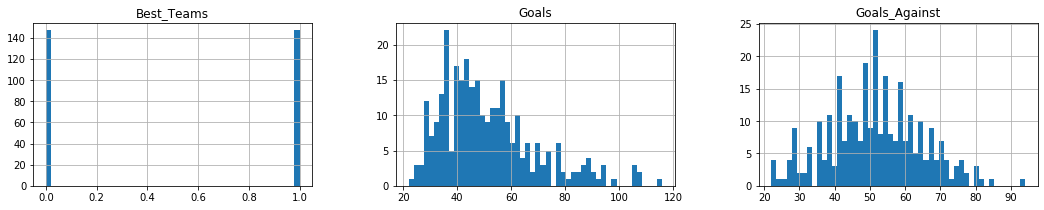

In [6]:
dt.hist(bins=50, figsize=(18, 3), layout=(1, 3))

Vemos que no hay escalas diferentes, tanto en Goals como en Goals_Against están en la misma escala y ciertamente parecidos, siguiendo unas distribuciones razonables.
<br>
También vemos que hay unos outliers en Goals, hay algunos pocos equipos que metieron más de 100 goles. Y en Goals_Against hay alguno también, fijémonos que hay algunos que recibieron más de 80 goles.

Echemos un vistazo a dichos equipos:

In [7]:
dt[dt['Goals'] > 100.0]

,TeamName,CompName,Season,Goals,Goals_Against,Position,Best_Teams
93,Manchester City FC,Premier League,2017-2018,106,27,1°,1
139,Paris Saint-Germain FC,Ligue 1,2018-2019,105,35,1°,1
140,Paris Saint-Germain FC,Ligue 1,2017-2018,108,29,1°,1
177,AS Monaco FC,Ligue 1,2016-2017,107,31,1°,1
232,Real Madrid CF,La Liga,2016-2017,106,41,1°,1
239,FC Barcelona,La Liga,2016-2017,116,37,2°,1


In [8]:
dt[dt['Goals_Against'] > 80.0]

,TeamName,CompName,Season,Goals,Goals_Against,Position,Best_Teams
32,Benevento Calcio,Serie A,2017-2018,33,84,20°,0
50,Delfino Pescara 1936,Serie A,2016-2017,37,81,20°,0
61,Fulham FC,Premier League,2018-2019,34,81,19°,0
229,Granada CF,La Liga,2016-2017,30,82,20°,0
237,CA Osasuna,La Liga,2016-2017,40,94,19°,0


### Train_set & Test_set

Vamos a separar nuestro set en dos partes, una para entrenar al modelo y otra para testarlo cuando acabemos de entrenarlo. 

In [9]:
# Fijamos el set de test en un 20% del original, y para entrenar el 80%.
size = 0.2
train_set, test_set = train_test_split(dt, test_size=size, random_state=42)

In [10]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 235 entries, 181 to 102
Data columns (total 7 columns):
TeamName         235 non-null object
CompName         235 non-null object
Season           235 non-null object
Goals            235 non-null int64
Goals_Against    235 non-null int64
Position         235 non-null object
Best_Teams       235 non-null int64
dtypes: int64(3), object(4)
memory usage: 14.7+ KB


In [11]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59 entries, 33 to 230
Data columns (total 7 columns):
TeamName         59 non-null object
CompName         59 non-null object
Season           59 non-null object
Goals            59 non-null int64
Goals_Against    59 non-null int64
Position         59 non-null object
Best_Teams       59 non-null int64
dtypes: int64(3), object(4)
memory usage: 3.7+ KB


### EDA: Exploratory Data Analysis

<strong>Vamos a trabajar con el set de entrenamiento (train_set)</strong>.

#### Correlaciones

In [12]:
corr_matrix = train_set.corr()
corr_matrix['Best_Teams'].sort_values(ascending=False)

Best_Teams       1.000000
Goals            0.607867
Goals_Against   -0.623922
Name: Best_Teams, dtype: float64

Esta matriz nos ofrece la correlación lineal entre variables, en este caso cada variable frente a Best_Teams. 
<br>
<br>
Hay una correlación de 0.6 entre los goles y la label a predecir, y a su vez una correlación de 0.62 entre Goals_Against y la label a predecir. Es decir, que cuantos más goles, mejor posición (1). Y que cuantos más goles encajas, peor posición (0), de ahí la relación negativa.

#### Heatmap

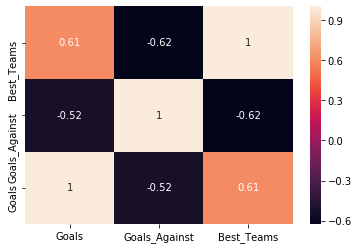

In [15]:
corr_matrix = train_set.corr()
heatmap = sn.heatmap(corr_matrix, annot=True)
heatmap.set(ylim=(0,len(corr_matrix)))
heatmap.set(xlim=(0,len(corr_matrix)))

plt.show()

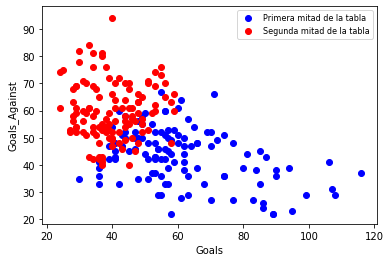

In [16]:
# Creamos dos datasets, cada uno para su mitad.
Mitad_1 = train_set[train_set['Best_Teams']==1]
Mitad_0 = train_set[train_set['Best_Teams']==0]

# Mostramos los dos datasets: en rojo los 10 peores y en azul los 10 mejores
plt.scatter(Mitad_1['Goals'], Mitad_1['Goals_Against'], marker='o', color='b')
plt.scatter(Mitad_0['Goals'], Mitad_0['Goals_Against'], marker='o', color='r')

# Ponemos los ejes
plt.xlabel("Goals")
plt.ylabel("Goals_Against")

# Escribimos la leyenda (qué épico suena)
plt.legend(('Primera mitad de la tabla', 'Segunda mitad de la tabla'), scatterpoints=1, loc='upper right', ncol=1, fontsize=8)

Podemos ver cómo hay más círculos azules (los que han quedado en la primera mitad de la tabla) cuantos más goles se meten. Hay algún outlier, pero se puede ver cómo dichos outliers han recibido poquísimos goles. Parece una tendencia muy lógica: o metemos muchos goles o nos encajan muy pocos, pero si no seguimos una tendencia así somos un equipo débil que quedará en la segunda mitad de tabla con riesgo de descenso.
Y del mismo modo vemos cómo hay equipos en rojo (segunda mitad) que no encajaron muchos goles y sí les encajaron muchos. Algunos metieron casi 60 goles, no está mal, pero recibieron casi 80, un balance muy pobre.

##### Conclusiones

 - Las variables Goals y Goals_Against son muy relevantes para predecir Best_Teams.
 - No hay valores nulos, podemos evitar el 'Data Cleaning'.

##### Preparación de los datos

Lo queremos hacer como una función porque más adelante, cuando tengamos que testar nuestro modelo con el set de test, tendremos que pasarle estas transformaciones a dicho set.

In [21]:
def PreparingData_v2(dt):
    dt = PreparingData(dt)
    dt = dt[['Goals', 'Goals_Against', 'Best_Teams']]
    
    return dt

In [22]:
train_set = PreparingData_v2(train_set)

Vamos a crear una función que nos separe el dataset procesado en features y labels.

In [23]:
def splitDT(dt, label):
    labels = dt[[label]]
    features = dt.drop([label], axis=1)

    return features, labels

### Modeling

En esta fase vamos a analizar:
 - Logistic Regression
 - KNN
 - SGD Classifier
 - Naive Bayes
 - SVM Classifier
 - Decision Tree Classifier
 - Random Forest Classifier

In [24]:
X_train, y_train = splitDT(train_set, 'Best_Teams')

In [25]:
def Display_Score(labels, predictions):
    acc = accuracy_score(labels, predictions)
    print("No Cross Validation")
    print("Accuracy Score: ", acc)
    print("----------")

In [26]:
def Display_CV_Scores(scores):
    print("Cross Validation")
    print("Accuracy Scores:", scores)
    print("Accuracy Mean:", scores.mean())
    print("Accuracy Standard deviation:", scores.std())

In [27]:
def VisualizeConfusionMatrix(X, y, pred):
    
    cm = confusion_matrix(y, pred)
    
    df_cm = pd.DataFrame(cm, columns=np.unique(y), index = np.unique(y))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    
    plt.figure(figsize = (6,4))

    heatmap = sn.heatmap(df_cm, cmap="Blues", annot=True, fmt='g')
    heatmap.set(ylim=(0,len(df_cm)))
    heatmap.set(xlim=(0,len(df_cm)))

#### Logistic Regression

No Cross Validation
Accuracy Score:  0.8808510638297873
----------
Cross Validation
Accuracy Scores: [0.95833333 0.79166667 0.83333333 0.875      0.91666667 0.91666667
 0.91666667 0.82608696 0.95454545 0.81818182]
Accuracy Mean: 0.8807147562582346
Accuracy Standard deviation: 0.056969307428383055


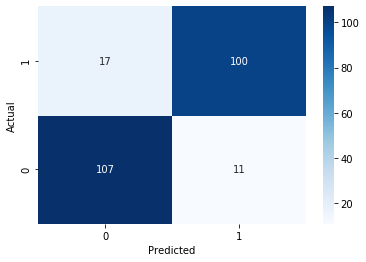

In [28]:
# Entrenamos el modelo
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

# Predicciones en el set de entrenamiento
lr_pred = lr.predict(X_train)

# Métricas obtenidas sin CV
Display_Score(y_train, lr_pred)

# Métricas obtenidas con CV
lr_cv = LogisticRegression(random_state=42)
lr_cv_scores = cross_val_score(lr_cv, X_train, y_train, scoring="accuracy", cv=10)
Display_CV_Scores(lr_cv_scores)

# Visualizacion
VisualizeConfusionMatrix(X_train, y_train, lr_pred)

Conclusiones de este modelo:
 - Podemos ver que no hace overfitting, ya que usando el CV el resultado es muy similar.
 - Vemos que el accuracy es muy alto, de un casi 90%.
 - Podemos ver que de la clase 0 (los peores de la temporada) tenemos un total de 118, de los cuales hemos predecido 107 bien. Sólo 11 hemos dicho que eran 1 pero en realidad eran 0.
 - Y de la clase 1 (los mejores de la temporada) tenemos un total de 117, de los cuales hemos predecido correctamente 100.
 - Los números no están nada mal, parece que con los goles que hace un equipo y los que encaja podemos encontrar cierta buena predicción para saber si quedarán en una mitad o en la otra, algo lógico por otro lado.

####  KNN

No Cross Validation
Accuracy Score:  0.8936170212765957
----------
Cross Validation
Accuracy Scores: [0.83333333 0.75       0.70833333 0.75       0.91666667 0.83333333
 0.83333333 0.82608696 0.72727273 0.86363636]
Accuracy Mean: 0.804199604743083
Accuracy Standard deviation: 0.0633957630272045


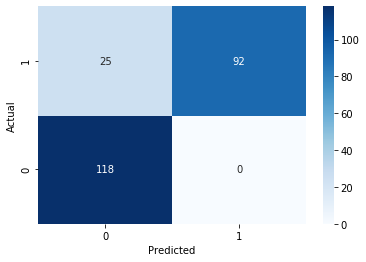

In [29]:
# Entrenamos el modelo
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)

# Predicciones en el set de entrenamiento
knn_pred = knn.predict(X_train)

# Métricas obtenidas sin CV
Display_Score(y_train, knn_pred)

# Métricas obtenidas con CV
knn_cv = KNeighborsClassifier(n_neighbors=3)
knn_cv_scores = cross_val_score(knn_cv, X_train, y_train, scoring="accuracy", cv=10)
Display_CV_Scores(knn_cv_scores)

# Visualizacion
VisualizeConfusionMatrix(X_train, y_train, knn_pred)

Conclusiones de este modelo:
 - Podemos ver que el accuracy sin CV es más alto, pero en CV vemos que baja mucho. Estamos detectando que el algoritmo hace overfitting.
 - Gestiona mejor la clase 0 que la 1, predice mejor los que van a quedar por abajo.

####  SGD Classifier

No Cross Validation
Accuracy Score:  0.8723404255319149
----------
Cross Validation
Accuracy Scores: [0.91666667 0.75       0.875      0.875      0.91666667 0.91666667
 0.91666667 0.82608696 0.86363636 0.86363636]
Accuracy Mean: 0.8720026350461133
Accuracy Standard deviation: 0.05013018328601314


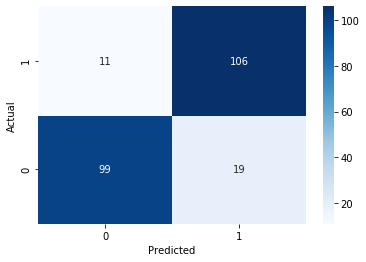

In [30]:
# Entrenamos el modelo
sgd = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd.fit(X_train, y_train)

# Predicciones en el set de entrenamiento
sgd_pred = sgd.predict(X_train)

# Métricas obtenidas sin CV
Display_Score(y_train, sgd_pred)

# Métricas obtenidas con CV
sgd_cv = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_cv_scores = cross_val_score(sgd_cv, X_train, y_train, scoring="accuracy", cv=10)
Display_CV_Scores(sgd_cv_scores)

# Visualizacion
VisualizeConfusionMatrix(X_train, y_train, sgd_pred)

Conclusiones de este modelo:
 - Muy similar a Logistic Regression, aunque un poco peor.
 - Vemos los resultados que no hacen overfitting, pero el accuracy y la matriz de confusión lucen peor.

####  Naive Bayes

No Cross Validation
Accuracy Score:  0.8638297872340426
----------
Cross Validation
Accuracy Scores: [0.95833333 0.83333333 0.875      0.875      0.95833333 0.875
 0.83333333 0.86956522 0.77272727 0.86363636]
Accuracy Mean: 0.8714262187088275
Accuracy Standard deviation: 0.052774777897353735


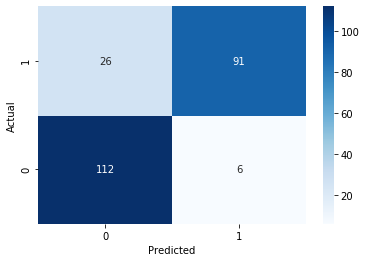

In [31]:
# Entrenamos el modelo
nb = GaussianNB()
nb.fit(X_train, y_train)

# Predicciones en el set de entrenamiento
nb_pred = nb.predict(X_train)

# Métricas obtenidas sin CV
Display_Score(y_train, nb_pred)

# Métricas obtenidas con CV
nb_cv = GaussianNB()
nb_cv_scores = cross_val_score(nb_cv, X_train, y_train, scoring="accuracy", cv=10)
Display_CV_Scores(nb_cv_scores)

# Visualizacion
VisualizeConfusionMatrix(X_train, y_train, nb_pred)

Conclusiones de este modelo:
 - Similar al anterior modelo, no hay overfitting y el accuracy es ligeramente peor.

####  SVM Classifier

No Cross Validation
Accuracy Score:  0.8808510638297873
----------
Cross Validation
Accuracy Scores: [0.95833333 0.79166667 0.83333333 0.875      0.91666667 0.91666667
 0.91666667 0.82608696 0.95454545 0.81818182]
Accuracy Mean: 0.8807147562582346
Accuracy Standard deviation: 0.056969307428383055


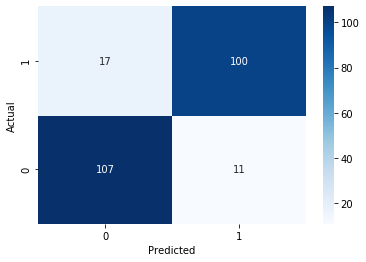

In [32]:
# Entrenamos el modelo
svm = LinearSVC(random_state=0, tol=1e-5)
svm.fit(X_train, y_train)

# Predicciones en el set de entrenamiento
svm_pred = svm.predict(X_train)

# Métricas obtenidas sin CV
Display_Score(y_train, svm_pred)

# Métricas obtenidas con CV
svm_cv = LinearSVC(random_state=0, tol=1e-5)
svm_cv_scores = cross_val_score(svm_cv, X_train, y_train, scoring="accuracy", cv=10)
Display_CV_Scores(svm_cv_scores)

# Visualizacion
VisualizeConfusionMatrix(X_train, y_train, svm_pred)

Conclusiones de este modelo:
 - Muy similar a logistic regression, siendo una métrica similar. 

####  Decision Tree Classifier

No Cross Validation
Accuracy Score:  0.9872340425531915
----------
Cross Validation
Accuracy Scores: [0.91666667 0.75       0.66666667 0.79166667 0.91666667 0.875
 0.79166667 0.7826087  0.77272727 0.77272727]
Accuracy Mean: 0.8036396574440052
Accuracy Standard deviation: 0.07410902684457252


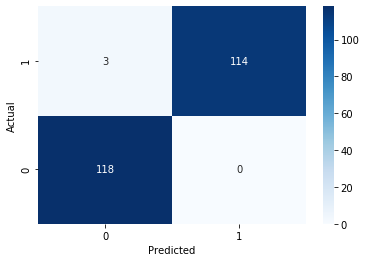

In [33]:
# Entrenamos el modelo
dtree = tree.DecisionTreeClassifier()
dtree.fit(X_train, y_train)

# Predicciones en el set de entrenamiento
dtree_pred = dtree.predict(X_train)

# Métricas obtenidas sin CV
Display_Score(y_train, dtree_pred)

# Métricas obtenidas con CV
dtree_cv = tree.DecisionTreeClassifier()
dtree_cv_scores = cross_val_score(dtree_cv, X_train, y_train, scoring="accuracy", cv=10)
Display_CV_Scores(dtree_cv_scores)

# Visualizacion
VisualizeConfusionMatrix(X_train, y_train, dtree_pred)

Conclusiones de este modelo:
 - Overfitting. Accuracy, casi del 100%, pero en CV baja al 80%. Y vemos cómo solo falla en 3 resultados en la matriz de confusión.

####  Random Forest Classifier

No Cross Validation
Accuracy Score:  0.8468085106382979
----------
Cross Validation
Accuracy Scores: [0.875      0.79166667 0.70833333 0.79166667 0.91666667 0.83333333
 0.91666667 0.7826087  0.81818182 0.86363636]
Accuracy Mean: 0.829776021080369
Accuracy Standard deviation: 0.061900329920275186


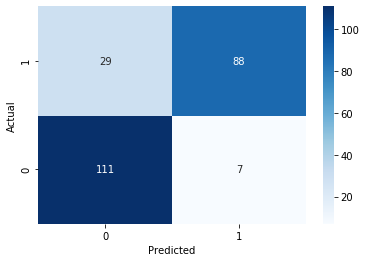

In [34]:
# Entrenamos el modelo
rf = RandomForestClassifier(max_depth=2, random_state=42)
rf.fit(X_train, y_train)

# Predicciones en el set de entrenamiento
rf_pred = rf.predict(X_train)

# Métricas obtenidas sin CV
Display_Score(y_train, rf_pred)

# Métricas obtenidas con CV
rf_cv = RandomForestClassifier(max_depth=2, random_state=42)
rf_cv_scores = cross_val_score(rf_cv, X_train, y_train, scoring="accuracy", cv=10)
Display_CV_Scores(rf_cv_scores)

# Visualizacion
VisualizeConfusionMatrix(X_train, y_train, rf_pred)

Conclusiones de este modelo:
 - No hay overfitting, pero las métricas son mucho peores que las vistas anteriormente.

### Hyperparameters

Vamos a proceder a seleccionar el mejor modelo con intención de<strong>mejorarlo para ver cual es nuestro modelo final con sus mejores hyperparameters.</strong>

El mejor modelo ha sido <strong>Logistic Regression</strong>, lo podemos ver en el accuracy que nos ha dado el modelo así como la matriz de confusión.

Best estimator: LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Best parameter (CV score=0.881):
----------
No Cross Validation
Accuracy Score:  0.8808510638297873
----------
Cross Validation
Accuracy Scores: [0.95833333 0.79166667 0.83333333 0.875      0.91666667 0.91666667
 0.91666667 0.82608696 0.95454545 0.81818182]
Accuracy Mean: 0.8807147562582346
Accuracy Standard deviation: 0.056969307428383055


C:\Users\egarc\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


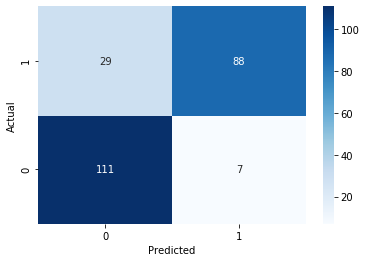

In [35]:
param_grid={"C":[0.1, 1, 2, 3, 4, 5], "penalty":["l1","l2"]}

# Entrenamos el modelo
grid = GridSearchCV(lr, param_grid, scoring="accuracy", cv=10, n_jobs=-1)
grid.fit(X_train, y_train)

# Obtenemos el mejor estimador y los mejores parámetros
best_model = grid.best_estimator_
best_params = grid.best_params_
print("Best estimator: " + str(best_model))
print("Best parameter (CV score=%0.3f):" % grid.best_score_)
print("----------")

# Predicciones en el set de entrenamiento
grid_pred = best_model.predict(X_train)

# Métricas obtenidas sin CV
Display_Score(y_train, grid_pred)

# Métricas obtenidas con CV
grid_cv_scores = cross_val_score(best_model, X_train, y_train, scoring="accuracy", cv=10)
Display_CV_Scores(grid_cv_scores)

# Visualizacion
VisualizeConfusionMatrix(X_train, y_train, rf_pred)

Conclusiones del modelo mejorado:
 - Hemos ejecutado el proceso probando diferentes hyperparameters para logistic regression, pero no ha habido mejora.
 - Sabemos cuales son los hyperparameters óptimos para este conjunto de datos y este modelo.
 - No hay overfitting comparando con CV y sin CV, por lo que no esperamos un resultado mucho peor en el testing.

### Evaluation

Una vez tenemos elegido el mejor modelo con los mejores hyperparameters, ejecutamos con los datos del set de test que no ha sido utilizado en ningún caso.

In [36]:
prep_test = PreparingData_v2(test_set)

prep_test.head()

,Goals,Goals_Against,Best_Teams
33,-0.093397,-0.402670,1
9,1.048403,-0.402670,1
146,-0.738763,1.271519,0
282,-0.540189,-0.163500,1
261,-1.185554,0.394563,0


In [37]:
X_test, y_test = splitDT(prep_test, 'Best_Teams')

Accuracy Score:  0.9152542372881356


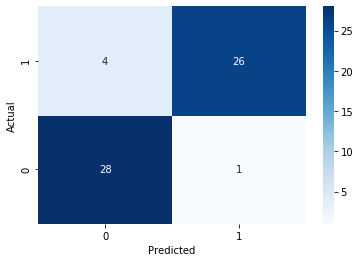

In [38]:
# Predicciones en el set de test
final_predictions = best_model.predict(X_test)

# Las métricas obtenidas en el test set
acc = accuracy_score(y_test, final_predictions)
print("Accuracy Score: ", acc)

# Visualizacion
VisualizeConfusionMatrix(X_test, y_test, final_predictions)

Conclusiones del modelo final y el set de test:
 - Los resultados mejoran, tenemos un accuracy del 92% en el set de test.
 - El algoritmo que hemos desarrollado predice con un accuracy muy interesante si un equipo va a quedar entre la primera mitad de la tabla o entre la segunda.
 - Funciona ligeramente mejor para la clase 0, es decir, para los que quedan entre los peores.

### Deployment

In [39]:
import joblib
joblib.dump(best_model, 'models/practica_clasificacion.pkl')

['models/practica_clasificacion.pkl']